In [1]:
import pandas 
import numpy
import scipy
import sys
import glob
import os 
import matplotlib.pyplot as plt

from matplotlib import colors
from osgeo import gdal 
from gdalconst import *

from skimage import exposure
from skimage.segmentation import felzenszwalb 
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Define Some Functions

In [2]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = numpy.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

# Load Raster and Vector Dataset

In [25]:
rpath = r'C:\Users\Rudy\Desktop\Processed UAV\KII Reflectance\KII_MSPA1A1_pca.tif'
vpath = r'C:\Users\Rudy\Desktop\Processed UAV\KII Reflectance\Mangrove'
r = r'C:\Users\Rudy\Desktop\Processed UAV\KII Reflectance\KII_MSPA1A1_transparent_reflectance_clip.tif'

In [11]:
raster = gdal.Open(r, gdal.GA_ReadOnly)
gt = raster.GetGeoTransform()
proj = raster.GetProjectionRef()
nband = raster.RasterCount
bands_array = []

for b in range (nband + 1)[1::]:
    band = raster.GetRasterBand(b)
    bands_array.append(band.ReadAsArray())
    
bands_array = numpy.dstack(b for b in bands_array)

# Segmetation of Images using Felzenszwalb 

In [12]:
img = exposure.rescale_intensity(bands_array)
band_segmentation = []
for i in range(nband):
    band_segmentation.append(felzenszwalb(img[:,:,i], scale=100, sigma=0.25, min_size=7))

In [13]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate (band_segmentation[1:]):
     segmentation += s*numpy.prod(const[:i+1])

_, labels = numpy.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

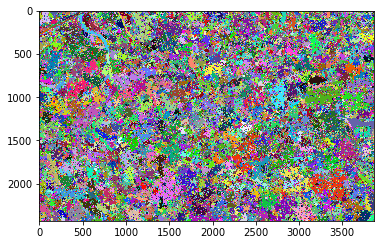

In [14]:
cmap = colors.ListedColormap(numpy.random.rand(len(numpy.unique(segments_felz)), 3))
plt.figure()
plt.rcParams['figure.figsize']=(50,30)
plt.imshow(segments_felz, interpolation='none', cmap=cmap)
plt.savefig('Felzenzswalb_40.png', bbox_inches='tight')

In [15]:
segments = segments_felz
segment_ids = numpy.unique(segments)
print ("No. of segments generated: ", len(segment_ids))

No. of segments generated:  264957


In [17]:
ras = gdal.Open(rpath, gdal.GA_ReadOnly)
gt = ras.GetGeoTransform()
proj = ras.GetProjectionRef()
nband = ras.RasterCount
bandsArray = []

for b in range (nband + 1)[1::]:
    band = ras.GetRasterBand(b)
    bandsArray.append(band.ReadAsArray())
    
bandsArray = numpy.dstack(b for b in bandsArray)
img2 = exposure.rescale_intensity(bandsArray)

# Calculate Statics of each Feature created from the Segmentation Process

In [18]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings

def segment_features(segment_pixels):
    """For each band , compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range (nbands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            band_stats[3] = 0.0
        features += band_stats
    return features

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img2[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

Created 264957 objects


# Create DataFrame from Segmented Objects

In [20]:
df = pandas.DataFrame(objects, dtype=numpy.float64)
df['prediction'] = numpy.nan
df

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,prediction
0,0.263661,0.967378,0.574509,1.041997e-01,0.386874,-1.821806,0.174203,0.364246,0.253565,0.007041,...,1.066476e-05,-0.050259,-1.646033,0.228789,0.245118,0.238001,4.925532e-05,-0.394019,-1.799686,NaN
1,0.133821,0.277160,0.206944,1.425626e-03,-0.137377,-0.454758,0.163858,0.237500,0.196325,0.000627,...,5.247892e-06,1.783430,5.420259,0.241984,0.246073,0.243815,8.239894e-07,0.023383,0.281820,NaN
2,0.046354,0.962496,0.174740,2.320086e-02,4.358818,19.639087,0.129454,0.383128,0.185064,0.001606,...,1.230445e-05,-0.100575,1.058726,0.228131,0.247194,0.243681,7.578920e-06,-4.661163,22.050420,NaN
3,0.200677,0.957184,0.769541,1.192875e-01,-1.155408,-0.663892,0.189112,0.378849,0.329094,0.007069,...,9.756159e-06,-1.155067,-0.664855,0.227974,0.245835,0.232708,5.923686e-05,1.156617,-0.641176,NaN
4,0.153150,0.277655,0.220497,1.483714e-03,-0.423676,-0.923899,0.193356,0.232260,0.213240,0.000180,...,3.453322e-06,0.577404,-0.668194,0.243067,0.246530,0.244507,9.788998e-07,0.542010,-0.270394,NaN
5,0.238033,0.277924,0.257363,1.497519e-04,0.112791,-0.560118,0.203211,0.220528,0.209660,0.000043,...,1.139826e-05,-0.649496,-1.154635,0.243427,0.245201,0.244524,4.406631e-07,-0.730689,-0.950359,NaN
6,0.200771,0.955049,0.315194,6.725609e-02,2.240304,3.072514,0.191351,0.377563,0.226737,0.003788,...,4.489130e-06,-0.592896,-0.745259,0.228338,0.243562,0.240980,2.628732e-05,-2.233841,3.058580,NaN
7,0.248830,0.954445,0.396716,9.727355e-02,1.497447,0.246549,0.216799,0.379398,0.253950,0.004941,...,7.310732e-06,-0.184811,-1.465095,0.228436,0.243578,0.240301,4.402376e-05,-1.497131,0.246258,NaN
8,0.168828,0.380450,0.301028,1.857656e-03,-0.681271,0.876702,0.216334,0.280904,0.250857,0.000267,...,1.040482e-05,-0.462453,1.730485,0.240735,0.245757,0.243064,8.556558e-07,0.093045,0.049991,NaN
9,0.312735,0.313766,0.313250,5.322606e-07,0.000000,-2.000000,0.223609,0.238256,0.230932,0.000107,...,2.447632e-06,0.000000,-2.000000,0.243055,0.243244,0.243150,1.782792e-08,0.000000,-2.000000,NaN


# Creating Training Data from ROIs

In [29]:
rows, cols, n_bands = img.shape
files = [f for f in os.listdir(vpath) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(vpath, f) for f in files if f.endswith('.shp')]
labels = []
for item in shapefiles:
    labels.append(item)
for counter, value in enumerate(labels):
    lhs, rhs = value.split("C:\\Users\\Rudy\\Desktop\\Processed UAV\\KII Reflectance\\Mangrove\\",1)
    lhs1, rhs1 = rhs.split(".shp",1)
    print ("class "+str(counter+1)+": "+lhs1)

class 1: Avicennia_marina
class 2: Avicennia_officinalis
class 3: Avicennia_rumphiana
class 4: Bruguiera_cylindrica
class 5: Built_up
class 6: Camptostemon_philippinensis
class 7: Ceriops_decandra
class 8: Coconut
class 9: Mangrove_1
class 10: Mangrove_2
class 11: Non_mangroves
class 12: Nypa_fruiticans
class 13: Sonneratia_alba
class 14: Water
class 15: Xylocarpus_granatum


In [30]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, gt, proj)

In [31]:
classes = numpy.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)

15

In [32]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 1: 23
Training segments for class 2: 50
Training segments for class 3: 135
Training segments for class 4: 9
Training segments for class 5: 62
Training segments for class 6: 6
Training segments for class 7: 6
Training segments for class 8: 109
Training segments for class 9: 4
Training segments for class 10: 1
Training segments for class 11: 72
Training segments for class 12: 141
Training segments for class 13: 15
Training segments for class 14: 9
Training segments for class 15: 32


###### Disambiguation 
Check if there are segments which contain training pixels of different classes.

In [34]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

AssertionError: 

In [35]:
train_img = numpy.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold
train_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

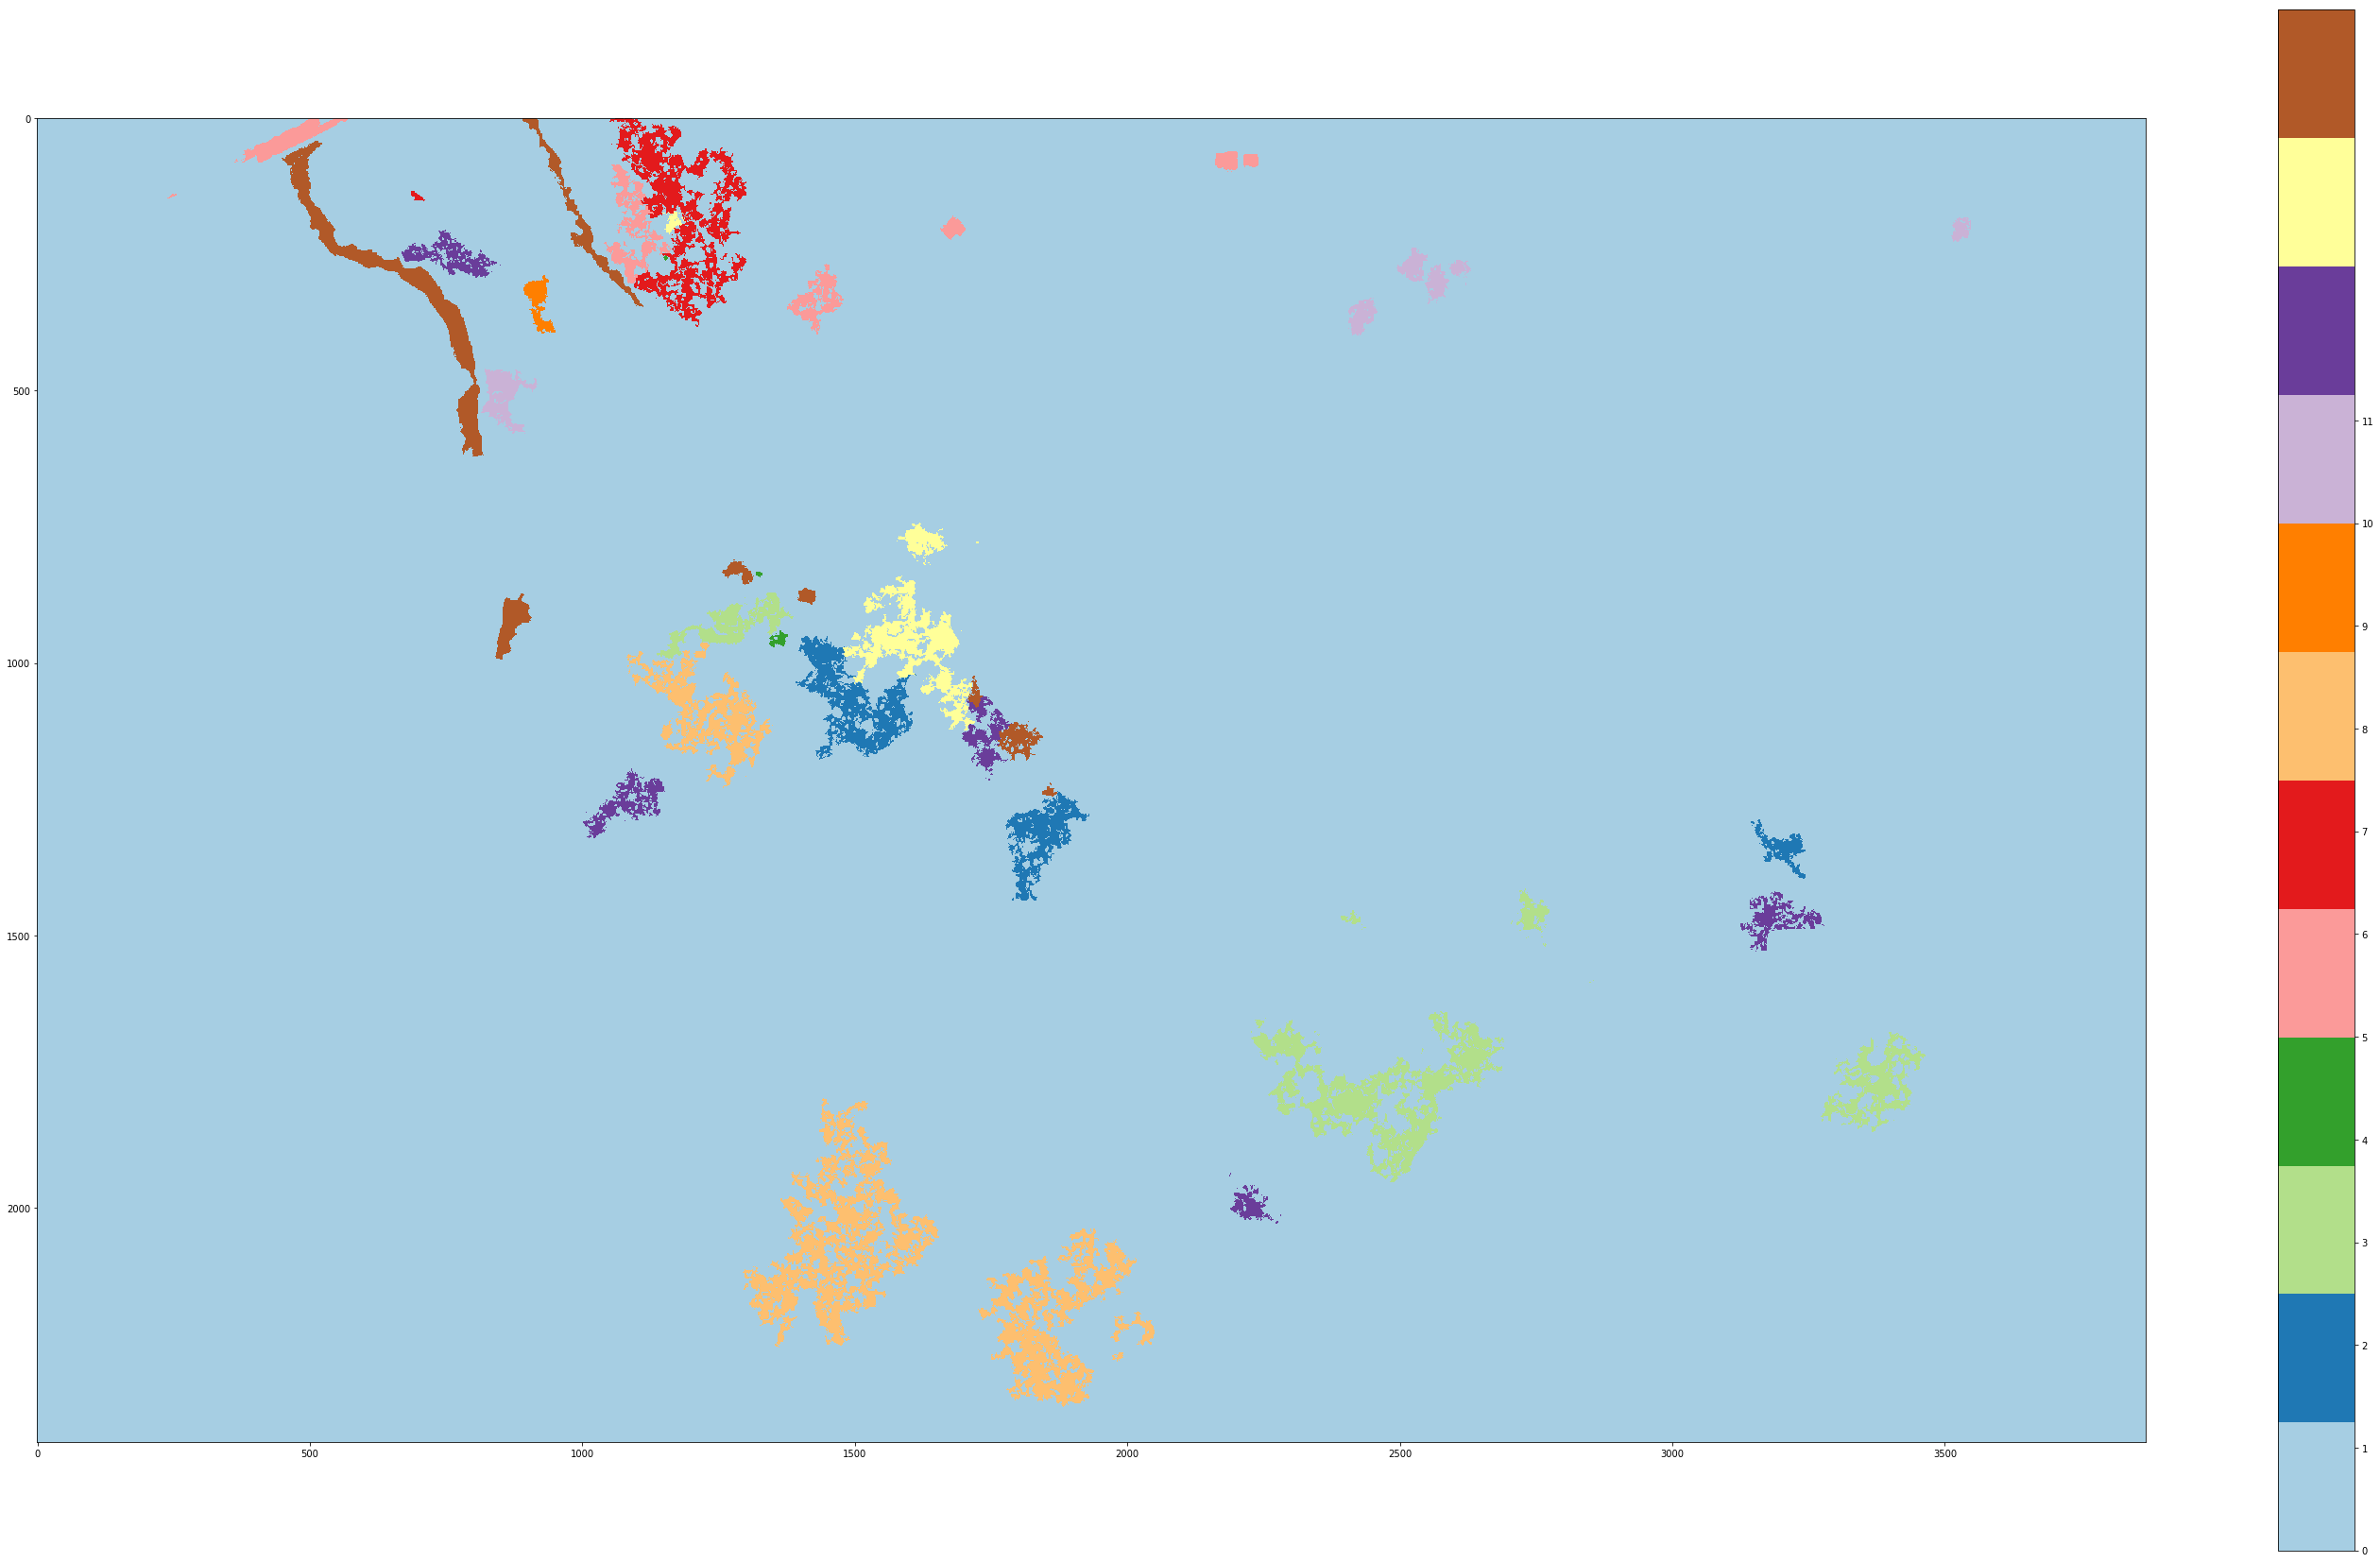

In [36]:
palette = plt.get_cmap('Paired')
plt.figure()
plt.rcParams['figure.figsize']=(50,30)
plt.imshow(train_img, cmap=palette)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11])

# Fit Data to Classifier

In [37]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

Training samples for class 1: 23
Training samples for class 2: 50
Training samples for class 3: 135
Training samples for class 4: 9
Training samples for class 5: 62
Training samples for class 6: 6
Training samples for class 7: 6
Training samples for class 8: 109
Training samples for class 9: 4
Training samples for class 10: 1
Training samples for class 11: 72
Training samples for class 12: 141
Training samples for class 13: 15
Training samples for class 14: 9
Training samples for class 15: 32


# Model Selection using K-fold Cross Validation

In [38]:
import pandas 
from matplotlib import pyplot

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

X = pandas.DataFrame(training_objects)
y = pandas.Series(training_labels)
training_labels

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0

In [39]:
sta = MinMaxScaler()
Xsta = sta.fit_transform(X)
Xsta

array([[ 0.20565222,  0.69690056,  0.47496341, ...,  0.13614159,
         0.62339589,  0.14142995],
       [ 0.36852071,  0.4390158 ,  0.40108374, ...,  0.05896169,
         0.36276933,  0.12122762],
       [ 0.48398738,  0.53458859,  0.50005992, ...,  0.02352009,
         0.54497448,  0.0783801 ],
       ..., 
       [ 0.19238289,  0.32915838,  0.24344343, ...,  0.07978576,
         0.43942445,  0.11197404],
       [ 0.30060562,  0.31216454,  0.30489537, ...,  0.02597157,
         0.32478675,  0.07153463],
       [ 0.25855178,  0.35623315,  0.30364306, ...,  0.0268541 ,
         0.39356148,  0.07801485]])

#### Machine Learning Algorithms

In [40]:
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier(n_estimators=1000)))
models.append(('ANN', MLPClassifier()))

In [41]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, Xsta, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print (msg)

c:\users\rudy\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
c:\users\rudy\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LDA: 0.833824 (0.053054)
KNN: 0.740408 (0.054765)
CART: 0.764113 (0.042739)
NB: 0.796620 (0.064884)
SVM: 0.417011 (0.076097)
RF: 0.857507 (0.057912)


c:\users\rudy\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\rudy\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ANN: 0.750856 (0.057191)


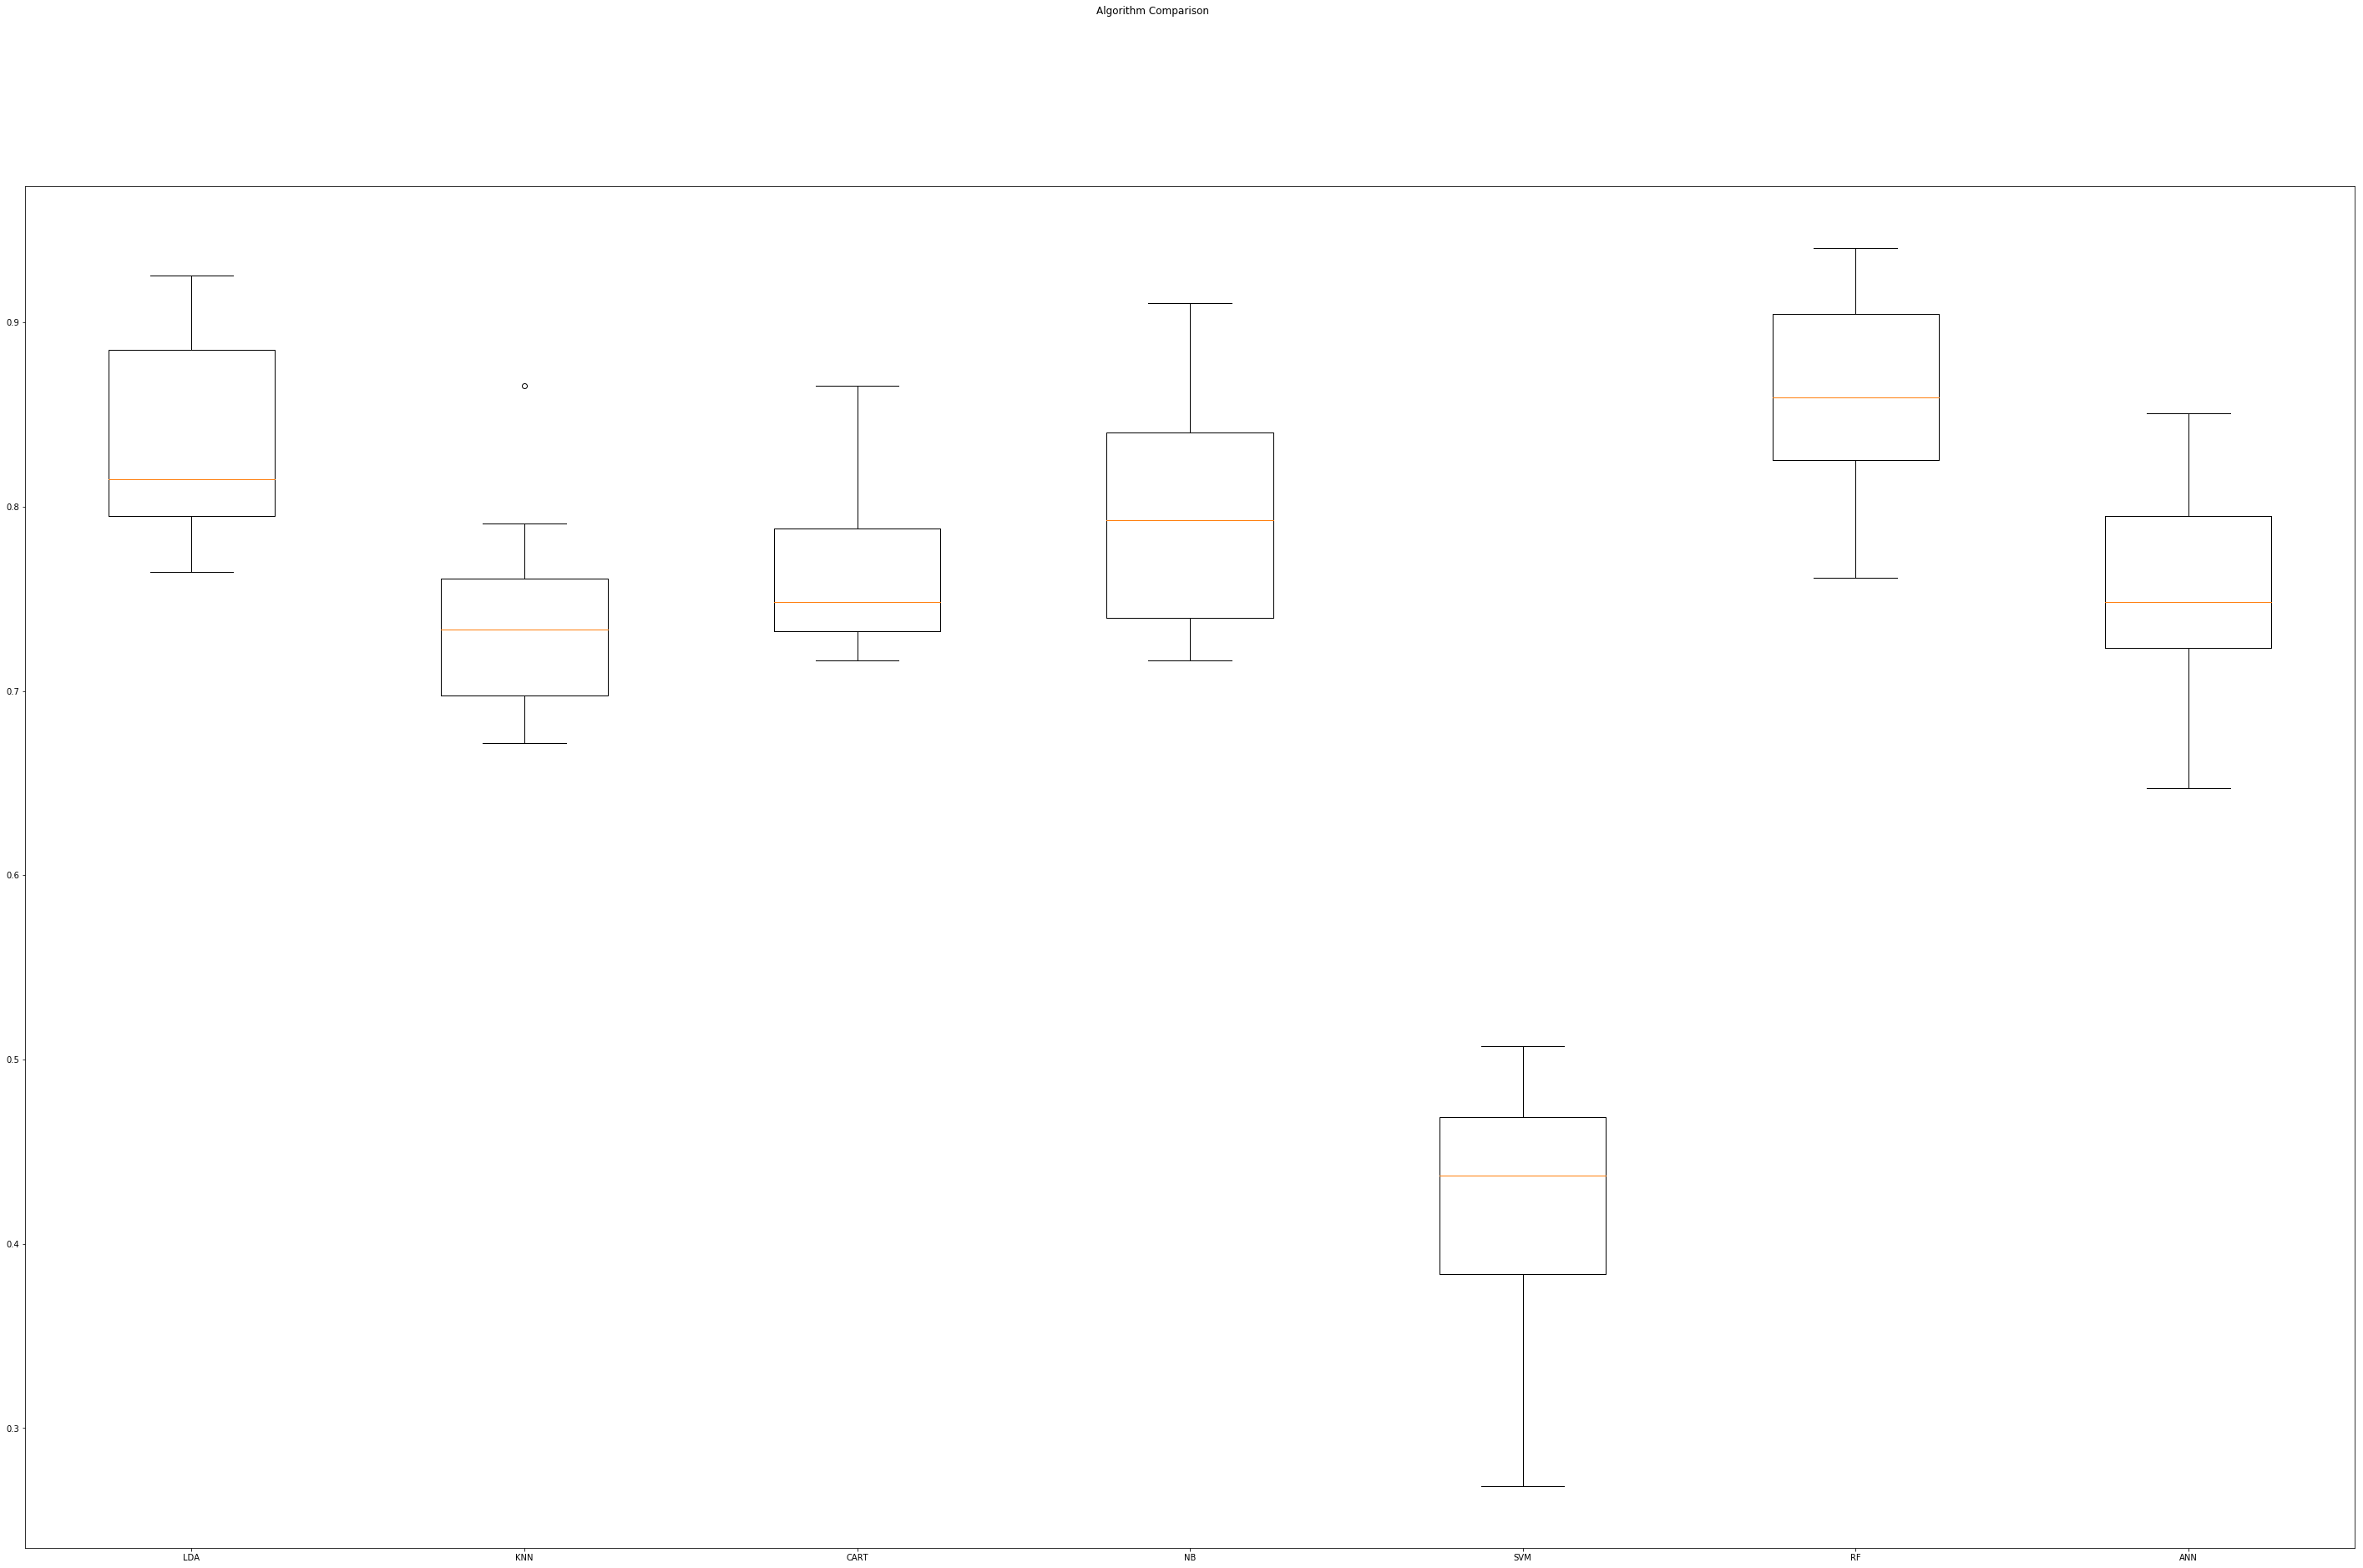

In [42]:
fig = pyplot.figure()
plt.rcParams['figure.figsize']=(7,6)
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()  

### Algorithm Tuning

In [43]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Xtrain,Xtest,yTrain,yTest = train_test_split(X,y, test_size = 0.2, random_state = 1)

In [44]:
#Random Forest Was chosen based on the K-Fold Cross Validation
for i in range (2,50):

    model = RandomForestClassifier(n_estimators=1000, min_samples_split=i)
    model.fit(Xtrain,yTrain)

    print (i)
    print ('train score', model.score(Xtrain,yTrain))
    print ('test score', model.score(Xtest,yTest))
    print ()

2
train score 0.99814471243
test score 0.792592592593

3
train score 0.99814471243
test score 0.792592592593

4
train score 0.99814471243
test score 0.814814814815

5
train score 0.99814471243
test score 0.8

6
train score 0.996289424861
test score 0.807407407407

7
train score 0.996289424861
test score 0.792592592593

8
train score 0.996289424861
test score 0.807407407407

9
train score 0.994434137291
test score 0.792592592593

10
train score 0.994434137291
test score 0.814814814815

11
train score 0.990723562152
test score 0.792592592593

12
train score 0.988868274583
test score 0.8

13
train score 0.981447124304
test score 0.792592592593

14
train score 0.979591836735
test score 0.792592592593

15
train score 0.975881261596
test score 0.8

16
train score 0.968460111317
test score 0.785185185185

17
train score 0.964749536178
test score 0.8

18
train score 0.961038961039
test score 0.785185185185

19
train score 0.949907235622
test score 0.8

20
train score 0.951762523191
test score 

In [45]:
estFinal = []
estFinal.append(('scale', StandardScaler()))
estFinal.append(('clf', RandomForestClassifier(n_estimators=1000, min_samples_split=10)))
modelFinal = Pipeline(estFinal)
modelFinal.fit(X,y)
modelFinal.score(X,y)

0.98961424332344217

In [46]:
X2 = df.iloc[:,:-1]
predicted = modelFinal.predict(X2)
predicted
df['prediction'] = predicted
df

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,prediction
0,0.263661,0.967378,0.574509,1.041997e-01,0.386874,-1.821806,0.174203,0.364246,0.253565,0.007041,...,1.066476e-05,-0.050259,-1.646033,0.228789,0.245118,0.238001,4.925532e-05,-0.394019,-1.799686,3.0
1,0.133821,0.277160,0.206944,1.425626e-03,-0.137377,-0.454758,0.163858,0.237500,0.196325,0.000627,...,5.247892e-06,1.783430,5.420259,0.241984,0.246073,0.243815,8.239894e-07,0.023383,0.281820,3.0
2,0.046354,0.962496,0.174740,2.320086e-02,4.358818,19.639087,0.129454,0.383128,0.185064,0.001606,...,1.230445e-05,-0.100575,1.058726,0.228131,0.247194,0.243681,7.578920e-06,-4.661163,22.050420,3.0
3,0.200677,0.957184,0.769541,1.192875e-01,-1.155408,-0.663892,0.189112,0.378849,0.329094,0.007069,...,9.756159e-06,-1.155067,-0.664855,0.227974,0.245835,0.232708,5.923686e-05,1.156617,-0.641176,3.0
4,0.153150,0.277655,0.220497,1.483714e-03,-0.423676,-0.923899,0.193356,0.232260,0.213240,0.000180,...,3.453322e-06,0.577404,-0.668194,0.243067,0.246530,0.244507,9.788998e-07,0.542010,-0.270394,3.0
5,0.238033,0.277924,0.257363,1.497519e-04,0.112791,-0.560118,0.203211,0.220528,0.209660,0.000043,...,1.139826e-05,-0.649496,-1.154635,0.243427,0.245201,0.244524,4.406631e-07,-0.730689,-0.950359,3.0
6,0.200771,0.955049,0.315194,6.725609e-02,2.240304,3.072514,0.191351,0.377563,0.226737,0.003788,...,4.489130e-06,-0.592896,-0.745259,0.228338,0.243562,0.240980,2.628732e-05,-2.233841,3.058580,3.0
7,0.248830,0.954445,0.396716,9.727355e-02,1.497447,0.246549,0.216799,0.379398,0.253950,0.004941,...,7.310732e-06,-0.184811,-1.465095,0.228436,0.243578,0.240301,4.402376e-05,-1.497131,0.246258,3.0
8,0.168828,0.380450,0.301028,1.857656e-03,-0.681271,0.876702,0.216334,0.280904,0.250857,0.000267,...,1.040482e-05,-0.462453,1.730485,0.240735,0.245757,0.243064,8.556558e-07,0.093045,0.049991,3.0
9,0.312735,0.313766,0.313250,5.322606e-07,0.000000,-2.000000,0.223609,0.238256,0.230932,0.000107,...,2.447632e-06,0.000000,-2.000000,0.243055,0.243244,0.243150,1.782792e-08,0.000000,-2.000000,3.0


In [47]:
clf = numpy.copy(segments)

In [48]:
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

outputPath = os.getcwd()
driver = raster.GetDriver()
nCols = raster.RasterXSize
nRows = raster.RasterYSize
columns2Ras = 'prediction'
ns = driver.Create(os.path.join(outputPath,'%s_KIIMSPA1A1_Classification.tif'%(columns2Ras)),\
                      nCols,nRows,1,GDT_Float32)
ns.SetGeoTransform(gt) 
ns.SetProjection(proj)
outputRas = ns.GetRasterBand(1)
outputRas.WriteArray(clf,0,0)
ns.FlushCache()
outputRas.FlushCache()
del outputRas,ns,clf

In [30]:
rgb_img = numpy.dstack([img[:, :, 3], img[:, :, 2], img[:, :, 1]])
plt.imshow(clf, cmap=colors.ListedColormap(numpy.random.rand(len(classes_labels), 3)))

NameError: name 'clf' is not defined

In [31]:
plt.figure()
plt.imshow(rgb_img)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001E52EF67840> (for post_execute):


ValueError: Image RGB array must be uint8 or floating point; found int16

ValueError: Image RGB array must be uint8 or floating point; found int16

In [32]:
import scipy
from scipy import ndimage
from scipy import misc

img = misc.imread('prediction_classes_RF.tif', flatten=True).astype(numpy.uint8)
img2 = ndimage.grey_erosion(img, size=(3,3))
erosion = ndimage.binary_erosion(img2).astype(numpy.uint8)
plt.imshow(erosion)

c:\users\rudy\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


FileNotFoundError: [Errno 2] No such file or directory: 'prediction_classes_RF.tif'

In [33]:
img.dtype

dtype('uint16')